# Scratch Detection

This notebook demonstrates scratch detection on wafer maps. For full dataset description and project overview, see README.


# Start work

In [2]:
import pandas as pd
import zipfile
from datetime import datetime

### Load Data

In [3]:
#load zip file
zf = zipfile.ZipFile('./data.zip') 

In [4]:
#load train data
df_wafers = pd.read_csv(zf.open('wafers_train.csv'))
df_wafers.head()

,WaferName,DieX,DieY,IsGoodDie,IsScratchDie
0,8PFrAN,0,27,True,False
1,8PFrAN,0,28,True,False
2,8PFrAN,0,29,True,False
3,8PFrAN,0,30,True,False
4,8PFrAN,0,31,True,False


In [5]:
#load test data
df_wafers_test = pd.read_csv(zf.open('wafers_test.csv'))
df_wafers_test.head()

,WaferName,DieX,DieY,IsGoodDie
0,mZa9ls,0,23,True
1,mZa9ls,0,24,True
2,mZa9ls,0,25,True
3,mZa9ls,0,26,True
4,mZa9ls,0,27,True


Function for draw wafers map to see how the wafers look like in the data. 

Using the function you can draw the wafer maps with or without labels:

In [6]:
def plot_wafer_maps(wafer_df_list, figsize, labels = True):
    """
    plot wafer maps for list of df of wafers

    :param wafer_df_list: list, The list of df's of the wafers
    :param figsize: int, the size of the figsize height 
    :param labels: bool, Whether to show the layer of labels (based on column 'IsScratchDie')
    
    :return: None
    """
    def plot_wafer_map(wafer_df, ax, map_type):
        wafer_size = len(wafer_df)
        s = 2**17/(wafer_size)
        if map_type == 'Label':
            mes = 'Scratch Wafer' if (wafer_df['IsScratchDie'] == True).sum()>0 else 'Non-Scratch Wafer'
        else:
            mes = 'Yield: ' + str(round((wafer_df['IsGoodDie']).sum()/(wafer_df['IsGoodDie']).count(), 2)) 
        
        ax.set_title(f'{map_type} | Wafer Name: {wafer_df["WaferName"].iloc[0]}, \nSum: {len(wafer_df)} dies. {mes}', fontsize=20)
        ax.scatter(wafer_df['DieX'], wafer_df['DieY'], color = 'green', marker='s', s = s)

        bad_bins = wafer_df.loc[wafer_df['IsGoodDie'] == False]
        ax.scatter(bad_bins['DieX'], bad_bins['DieY'], color = 'red', marker='s', s = s)
        
        if map_type == 'Label':
            scratch_bins = wafer_df.loc[(wafer_df['IsScratchDie'] == True) & (wafer_df['IsGoodDie'] == False)]
            ax.scatter(scratch_bins['DieX'], scratch_bins['DieY'], color = 'blue', marker='s', s = s)

            ink_bins = wafer_df.loc[(wafer_df['IsScratchDie'] == True) & (wafer_df['IsGoodDie'] == True)]
            ax.scatter(ink_bins['DieX'], ink_bins['DieY'], color = 'yellow', marker='s', s = s)

            ax.legend(['Good Die', 'Bad Die', 'Scratch Die', 'Ink Die'], fontsize=8)
        else:
            ax.legend(['Good Die', 'Bad Die'], fontsize=8)

        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False) 
    
    import numpy as np
    import matplotlib.pyplot as plt
    
    if labels:
        fig, ax = plt.subplots(2, len(wafer_df_list), figsize=(figsize*len(wafer_df_list), figsize*2))
        for idx1, wafer_df in enumerate(wafer_df_list):
            for idx2, map_type in enumerate(['Input', 'Label']):
                plot_wafer_map(wafer_df, ax[idx2][idx1], map_type)
    else:
        fig, ax = plt.subplots(1, len(wafer_df_list), figsize=(figsize*len(wafer_df_list), figsize))
        for idx, wafer_df in enumerate(wafer_df_list):
            plot_wafer_map(wafer_df, ax[idx], 'Input')

    plt.show()

Select the amount of samples you want to display:

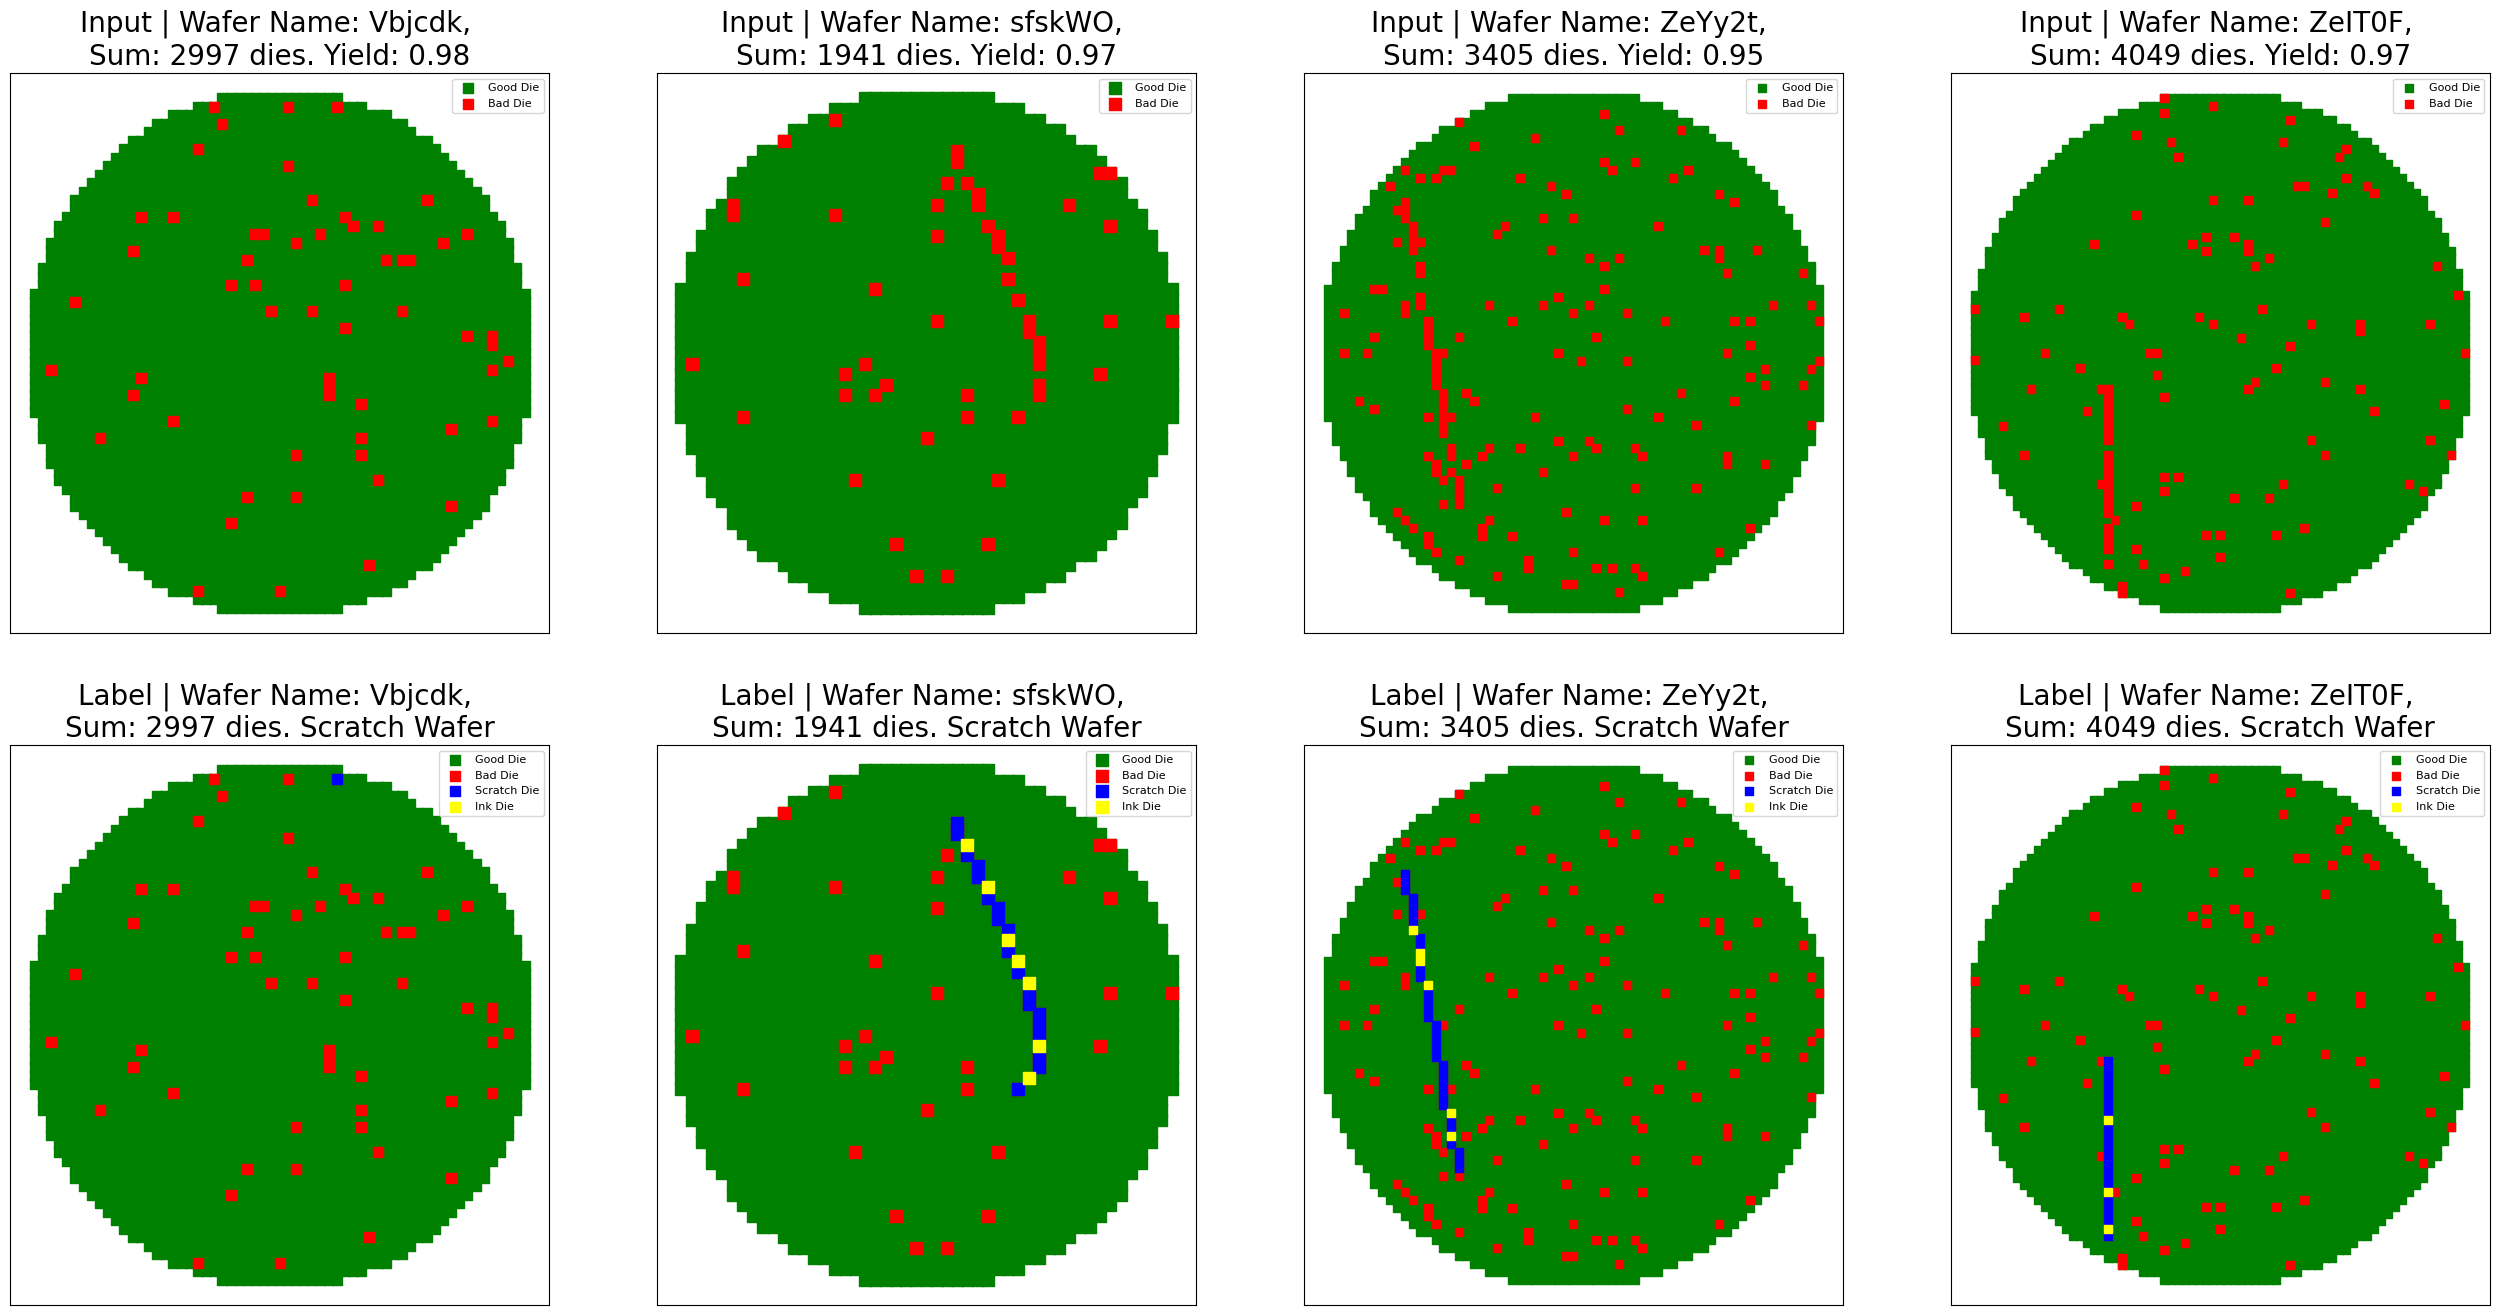

In [7]:
n_samples = 4
list_sample_train = [df_wafers.groupby('WaferName').get_group(group) for group in df_wafers['WaferName'].value_counts().sample(n_samples, random_state=20).index]
plot_wafer_maps(list_sample_train, figsize = 8, labels = True)

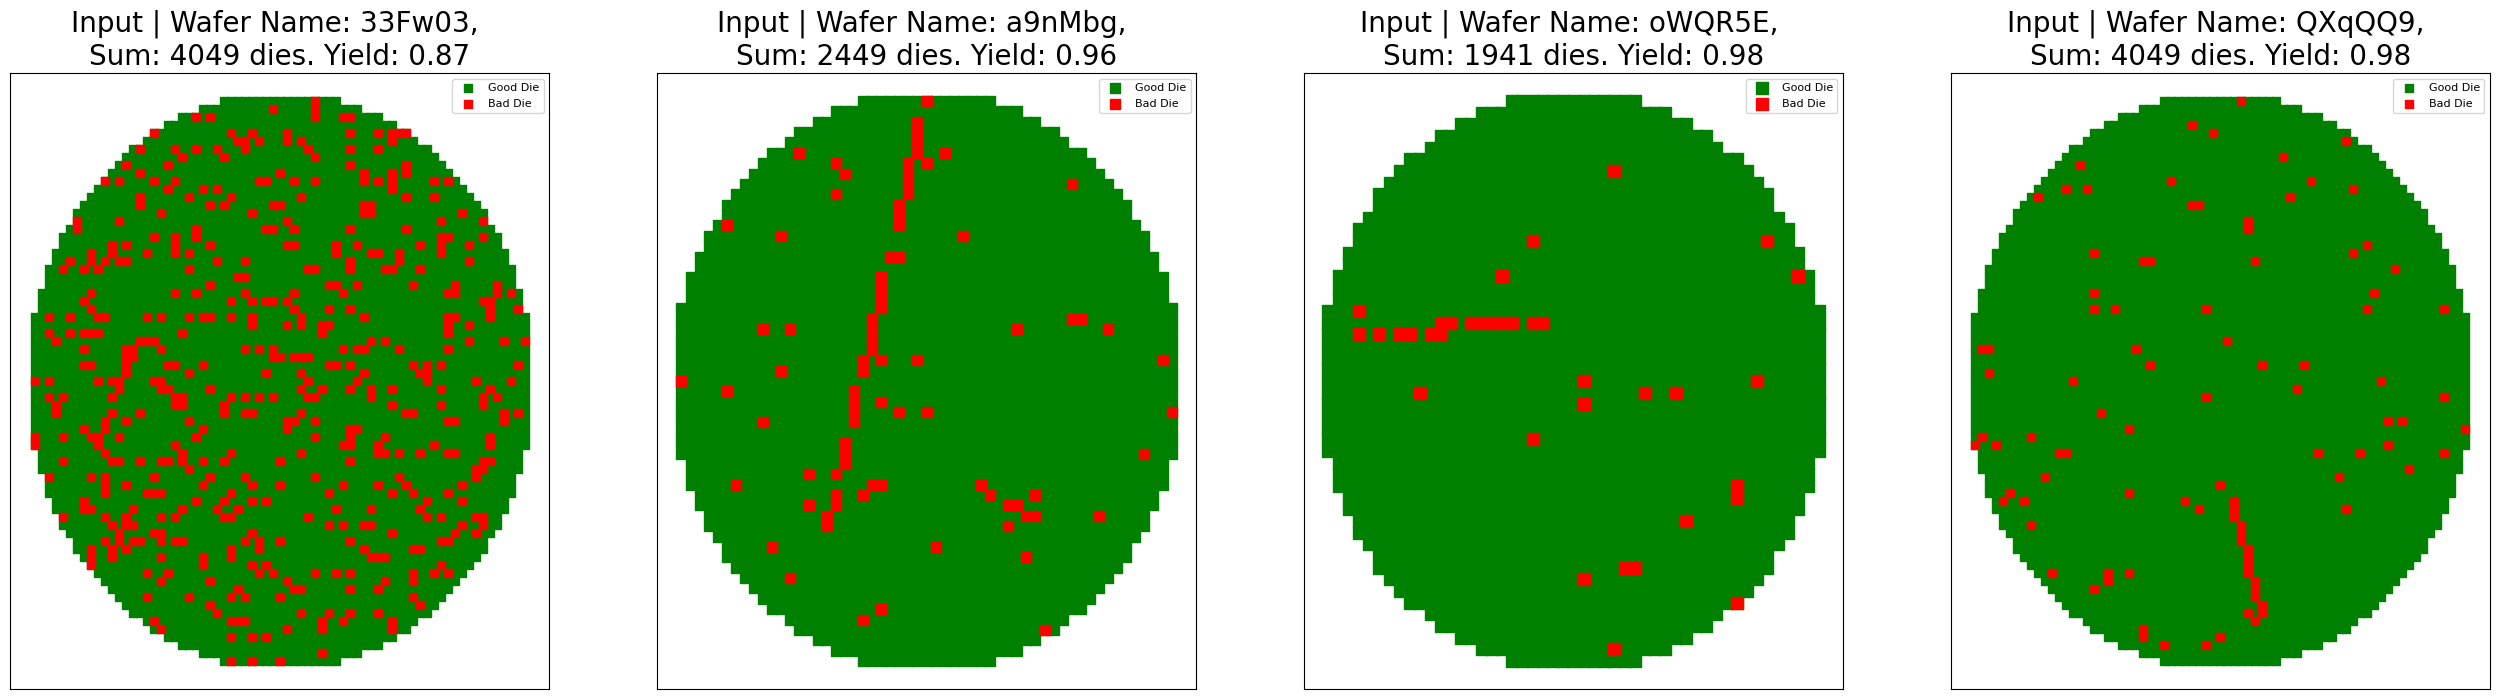

In [8]:
list_sample_test = [df_wafers_test.groupby('WaferName').get_group(group) for group in df_wafers_test['WaferName'].value_counts().sample(n_samples, random_state=20).index]
plot_wafer_maps(list_sample_test, figsize = 8, labels = False)

# Solution

### Solution Summary

In this notebook, I implemented a solution for detecting scratches on semiconductor wafers by classifying individual dies. My approach includes:

- Designing and extracting a set of meaningful features that capture local die behavior (e.g., neighbor fail counts, linearity, streak lengths).
- Implementing a Gradient Boosted Trees (XGBoost) model to perform binary classification.
- Using Optuna for automated hyperparameter optimization over a validation split (10% of wafers).
- Applying yield-based filtering to remove extremely noisy wafers from training.
- Tuning the decision threshold to balance precision and recall on validation results.
- Generating final predictions for the test set and exporting them in the required format.

Alternative methods such as CNN-based patch classification were explored, but not used due to training time constraints.


### Action Plan

1. **Training Data Feature Preparation**  
   Generate engineered features for each die using geometric and neighborhood patterns.

2. **Hyperparameter Tuning**  
   Use Optuna to search for the best XGBoost parameters on a 10% wafer-level validation split.

3. **Model Training & Evaluation**  
   Train on the selected training set and evaluate performance using precision, recall, and F1 score.

4. **Full Training Set Preparation**  
   Include yield-based filtering and re-prepare the feature matrix for final training.

5. **Final Model Training**  
   Retrain the model with optimal parameters on the full dataset and perform early stopping.

6. **Model Introspection**  
   Analyze the number of trees and feature importance in the trained model.

7. **Prediction on Test Set**  
   Generate test set features, apply filtering, and predict scratch membership for each die.


In [ ]:
import json
import optuna
import zipfile
import numpy as np
import pandas as pd
import xgboost as xgb
from datetime import datetime
import matplotlib.pyplot as plt
from skimage.morphology import closing, footprint_rectangle, skeletonize
from sklearn.model_selection import GroupKFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import precision_recall_curve, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score

###  *1.* Training Data Feature Preparation

In this step, I construct informative features from the raw wafer maps.



In [10]:
# Load data
zf = zipfile.ZipFile("./data.zip")
df_train = pd.read_csv(zf.open("wafers_train.csv"))

# Preprocess data, convert True/False to 1/0
df_train["IsGoodDie"] = df_train["IsGoodDie"].astype(int)
df_train["IsScratchDie"] = df_train["IsScratchDie"].astype(int)

def compute_wafer_features(wafer_df):
    ''' 
    Compute features for a wafer die map.
    :param wafer_df: DataFrame containing wafer data
    :return: DataFrame with computed features    
    '''

    # Extract coordinates and labels 
    xs, ys = wafer_df["DieX"].values, wafer_df["DieY"].values
    good = wafer_df["IsGoodDie"].values  # 1=good,0=fail

    # Normalize coordinates
    min_x, min_y = xs.min(), ys.min()
    x_coords, y_coords = xs - min_x, ys - min_y
    width, height = int(x_coords.max()) + 1, int(y_coords.max()) + 1

    # Build fail map and present map
    # fail_map: 1=fail, 0=good
    # present: 1=present, 0=absent
    fail_map = np.zeros((height, width), dtype=np.uint8)
    present  = np.zeros_like(fail_map)
    for x, y, g in zip(x_coords, y_coords, good):
        present[y, x] = 1
        if g == 0:
            fail_map[y, x] = 1

    # Compute wafer yield
    wafer_yield = good.sum() / present.sum()

    # Helper: compute run‐length streaks for fail_map
    def streaks(arr):
        ''' 
        Compute run‐length streaks in four directions (left, right, up, down).
        :param arr: 2D array of 0s and 1s
        :return: four 2D arrays of the same shape as arr, each containing the run lengths

        example:
        arr = np.array([[1, 0, 1],
                        [1, 1, 0],
                        [0, 1, 1]])
        left_run = np.array([[1, 0, 1],
                             [2, 1, 0],
                             [0, 1, 2]])
        '''
        # initialize all four direction arrays
        left_run = np.zeros_like(arr); run_right = left_run.copy()
        up_run = left_run.copy(); down_run = left_run.copy()
        # Horizontal
        for r in range(height):
            run = 0
            for c in range(width):
                run = run + 1 if arr[r, c] else 0
                left_run[r, c] = run
            run = 0
            for c in range(width-1, -1, -1):
                run = run + 1 if arr[r, c] else 0
                run_right[r, c] = run
        # Vertical
        for c in range(width):
            run = 0
            for r in range(height):
                run = run + 1 if arr[r, c] else 0
                down_run[r, c] = run
            run = 0
            for r in range(height-1, -1, -1):
                run = run + 1 if arr[r, c] else 0
                up_run[r, c] = run
        return left_run, run_right, up_run, down_run
    
    # Compute run‐lengths in four directions
    left_fail_run, right_fail_run, up_fail_run, down_fail_run = streaks(fail_map)

    # Immediate neighbor counts around each die (3×3 window)
    def neighbor_count(arr):
        '''
        Compute the number of neighboring fails (1s) for each die in a 3×3 window.
        :param arr: 2D array of 0s and 1s
        :return: 2D array of the same shape as arr, with counts of neighboring fails
        :note: The center die is excluded from the count.

        Example:
        arr = np.array([[1, 0, 1],
                        [1, 1, 0],
                        [0, 1, 1]])
        neighbor_count = np.array([[2, 3, 2],
                                   [3, 4, 2],
                                   [2, 2, 1]])
        '''
        pad = np.pad(arr, 1, mode='constant', constant_values=0)
        nb = (
            pad[0:height,   0:width] + pad[0:height,   1:width+1] + pad[0:height,   2:width+2] +
            pad[1:height+1, 0:width]               + pad[1:height+1, 2:width+2] +
            pad[2:height+2, 0:width] + pad[2:height+2, 1:width+1] + pad[2:height+2, 2:width+2]
        )
        nb[arr == 1] -= 1
        return nb

    # Count the number of fails in the immediate neighborhood
    neighbor_fail_count = neighbor_count(fail_map)

    # Skeleton of the fail_map
    skel_f = skeletonize(fail_map > 0).astype(np.uint8)

    # Elementary structure for morphological operations
    size_elem = footprint_rectangle((3, 3))

    # morphological closing of the fail map (fills 1-pixel holes)
    closed_fail_map = closing(fail_map > 0, size_elem).astype(np.uint8)


    feats = []
    # Iterate over each die in the wafer map
    # Compute features for each die
    for _, row in wafer_df.iterrows():
        x0 = int(row["DieX"] - min_x)
        y0 = int(row["DieY"] - min_y)
        is_fail = 1 - row["IsGoodDie"]

        # Fail‐based run‐lengths
        # Horizontal and vertical lengths
        hl_f = (left_fail_run[y0, x0] - 1 if is_fail else (left_fail_run[y0, x0-1] if x0 > 0 else 0)) + \
               (right_fail_run[y0, x0] - 1 if is_fail else (right_fail_run[y0, x0+1] if x0 < width-1 else 0)) + is_fail
        vl_f = (up_fail_run[y0, x0] - 1 if is_fail else (up_fail_run[y0-1, x0] if y0 > 0 else 0)) + \
               (down_fail_run[y0, x0] - 1 if is_fail else (down_fail_run[y0+1, x0] if y0 < height-1 else 0)) + is_fail

        # Neighbor fail count
        nbr_f    = neighbor_fail_count[y0, x0]

        # Check if the die is on the skeleton
        on_skeleton_f  = int(skel_f[y0, x0])

        # Check if the die is on the closed fail map
        on_closed_fail = int(closed_fail_map[y0, x0])

        # Local fail linearity in a 5×5 patch
        points = [
            (nx, ny)
            for dy in range(-2, 3)
            for dx in range(-2, 3)
            for nx, ny in [(x0 + dx, y0 + dy)]
            if 0 <= ny < height and 0 <= nx < width and fail_map[ny, nx] # is fail and in bounds of wafer
        ]
        lin_f = 0.0
        if len(points) >= 3:
            pts_arr = np.array(points)
            lin_f = LinearRegression().fit(pts_arr[:, 0:1], pts_arr[:, 1]).score(
                pts_arr[:, 0:1], pts_arr[:, 1]
            )

        feats.append({
            "DieX":               row["DieX"],
            "DieY":               row["DieY"],
            "is_fail":            is_fail,
            "horiz_len":          hl_f,
            "vert_len":           vl_f,
            "neighbor_fail_count": nbr_f,
            "on_skeleton":        on_skeleton_f,
            "local_linearity":    lin_f,
            "wafer_yield":        wafer_yield,
            "on_closed_fail": on_closed_fail
        })

    return pd.DataFrame(feats)

# Build df_train_feats without scratch‐map features
# for each wafer in df_train, compute features 
rows = []
for name, grp in df_train.groupby("WaferName"):
    feats = compute_wafer_features(grp)
    feats["WaferName"] = name
    feats["scratch_label"] = grp["IsScratchDie"].values
    rows.append(feats)

df_train_feats = pd.concat(rows, ignore_index=True)

### *2.* Hyperparameter Tuning & Cross-Validation
Use Optuna to explore different XGBoost configurations.
A 10% wafer-level validation split helps to find parameters that generalize well while preventing overfitting.


<details>
<summary><strong>Hyperparameter Descriptions</strong></summary>

- **max_depth**  
  Maximum depth of each tree. Controls model complexity—deeper trees can fit more complex patterns but may overfit.

- **eta** (learning rate)  
  Shrinks the contribution of each new tree. Lower values slow down training and often improve generalization.

- **subsample**  
  Fraction of the training instances sampled for each tree. Values < 1.0 introduce randomness and help prevent overfitting.

- **colsample_bytree**  
  Fraction of features (columns) sampled per tree. Smaller values speed up training and reduce correlation between trees.

- **min_child_weight**  
  Minimum sum of instance weight (Hessian, second derivative) required in a leaf. Larger values make the algorithm more conservative, avoiding splits on noisy data.

- **scale_pos_weight**  
  Balances the weight of positive vs. negative classes, which is crucial when your data is imbalanced.

</details>


In [ ]:
feature_cols = [
    "is_fail",
    "horiz_len",
    "vert_len",
    "neighbor_fail_count",
    "on_skeleton",
    "local_linearity",
    "wafer_yield",
    "on_closed_fail"
]
# Filter out low‐yield wafers to reduce noise in the data
yield_threshold = 0.7  # drop any wafer whose overall yield < 70%
df_train_feats = df_train_feats[df_train_feats["wafer_yield"] >= yield_threshold]

# Create feature matrix and target vector (X and y)
# X: feature matrix
# y: target vector
x_feature_matrix = df_train_feats[feature_cols].values
y = df_train_feats["scratch_label"].values
groups = df_train_feats["WaferName"].values

def objective(trial):
    '''
    Objective function for Optuna hyperparameter optimization.
    :param trial: Optuna trial object
    :return: F1 score for the current trial'''

    # Define hyperparameters to optimize and their ranges
    params = {
        "objective":        "binary:logistic",
        "eval_metric":      "auc",
        "tree_method":      "gpu_hist",
        "predictor":        "gpu_predictor",
        "verbosity":        0,
        "max_depth":        trial.suggest_int("max_depth", 4, 25),
        "eta":              trial.suggest_loguniform("eta", 0.01, 0.3),
        "subsample":        trial.suggest_uniform("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.6, 1.0),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 20),
        "scale_pos_weight": trial.suggest_categorical(
            "scale_pos_weight",
            [(y == 0).sum() / (y == 1).sum(), 1.0, 2.0, 3.0, 4.0, 5.0]
        ),
    }

    # Use GroupKFold for cross-validation
    gkf = GroupKFold(n_splits=10)
    fold_f1 = []

    for tr_idx, va_idx in gkf.split(x_feature_matrix, y, groups=groups):
        X_tr, X_va = x_feature_matrix[tr_idx], x_feature_matrix[va_idx]
        y_tr, y_va = y[tr_idx], y[va_idx]

        dtrain = xgb.DMatrix(X_tr, label=y_tr)
        dvalidation = xgb.DMatrix(X_va, label=y_va)
        
        bst = xgb.train(
            params,
            dtrain,
            num_boost_round=200,
            evals=[(dtrain, "train"), (dvalidation, "val")],
            early_stopping_rounds=10,
            verbose_eval=False
        )

        preds = bst.predict(dvalidation)
        p, r, thresholds = precision_recall_curve(y_va, preds)
        f1s = 2 * p * r / (p + r + 1e-8)
        fold_f1.append(f1s.max())
        
    # Calculate the mean F1 score across all folds
    return np.mean(fold_f1)

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100, show_progress_bar=True)

print("Best CV F1:", study.best_value)
print("Best hyperparameters:")
for k, v in study.best_trial.params.items():
    print(f"  • {k}: {v}")

### *3.* Model Training & Evaluation 
The best parameters from tuning (In the cell above) are used to train the model. I evaluate its performance using precision, recall, F1 score, and AUC on the hold-out wafers.

In [ ]:

# Set random seed for having reproducible results.
# This is important for ensuring that the results of the model training and evaluation are consistent across different runs.
np.random.seed(42)

# split the data into training and validation sets
all_wafers = df_train_feats["WaferName"].unique()
val_wafers = np.random.choice(all_wafers, size=int(0.1 * len(all_wafers)), replace=False)
df_val = df_train_feats[df_train_feats["WaferName"].isin(val_wafers)]
df_tr  = df_train_feats[~df_train_feats["WaferName"].isin(val_wafers)]


X_tr, y_tr = df_tr[feature_cols].values, df_tr["scratch_label"].values
X_va, y_va = df_val[feature_cols].values, df_val["scratch_label"].values


dtrain = xgb.DMatrix(X_tr, label=y_tr)
dvalid = xgb.DMatrix(X_va, label=y_va)

# Best params from Optuna ( above cell output)
best_params = {
    "objective":        "binary:logistic",
    "eval_metric":      "auc",
    "tree_method":      "gpu_hist",
    "predictor":        "gpu_predictor",
    "verbosity":        0,
    "max_depth":        12,
    "eta":              0.13116361714661062,
    "subsample":        0.8229600960547472,
    "colsample_bytree": 0.8813934420784457,
    "min_child_weight": 10,
    "scale_pos_weight": 4.0
}

#Train final booster with early stopping
final_booster = xgb.train(
    best_params,
    dtrain,
    num_boost_round=200,
    evals=[(dtrain, "train"), (dvalid, "val")],
    early_stopping_rounds=10,
    verbose_eval=False
)

#Determine optimal threshold on the training portion
train_probs = final_booster.predict(dtrain)
p, r, ths = precision_recall_curve(y_tr, train_probs)
f1s = 2 * p * r / (p + r + 1e-8)
best_thresh = ths[f1s.argmax()]
print(f"Optimal probability threshold for max F1 on train: {best_thresh:.3f}")

# Evaluate on held-out 10% wafers
val_probs = final_booster.predict(dvalid)
val_pred  = (val_probs >= best_thresh).astype(int)

print("\nFinal Held-Out Metrics")
print(f"Precision: {precision_score(y_va, val_pred, zero_division=0):.3f}")
print(f"Recall:    {recall_score(  y_va, val_pred, zero_division=0):.3f}")
print(f"F1:        {f1_score(     y_va, val_pred, zero_division=0):.3f}")
print(f"AUC:       {roc_auc_score(y_va, val_probs):.3f}")

# Print confusion matrix
conf_matrix =confusion_matrix(y_va, val_pred)

# Wrap in a DataFrame with meaningful labels
cm_df = pd.DataFrame(
    conf_matrix,
    index=["Actual Non-Scratch","Actual Scratch"],
    columns=["Predicted Non-Scratch","Predicted Scratch"]
)

print(cm_df)


Optimal probability threshold for max F1 on train: 0.725

 Final Held-Out Metrics
Precision: 0.820
Recall:    0.733
F1:        0.774
AUC:       0.996
                    Predicted Non-Scratch  Predicted Scratch
Actual Non-Scratch                1008307               1242
Actual Scratch                       2056               5651


### *4.* Full Training Set Preparation

Here I reprocess the entire training set, filtering out wafers with extremely low yield. These wafers can add noise and mislead the model.


In [18]:

# Filter out low‐yield wafers
yield_threshold = 0.7  # drop any wafer whose overall yield < 70%
df_train_filtered = df_train_feats[df_train_feats["wafer_yield"] >= yield_threshold]

# Build feature matrix and labels
X_full = df_train_filtered[feature_cols].values
y_full = df_train_filtered["scratch_label"].values

# Create DMatrix for training
dtrain = xgb.DMatrix(X_full, label=y_full)

### *5.* Final Model Training

I retrain the model using the full dataset and optimal parameters, applying early stopping for efficiency and generalization.


In [19]:

# Train the final model on the full dataset
bst_full = xgb.train(
    best_params,
    dtrain,
    num_boost_round=2000,
    evals=[(dtrain, "train")],
    early_stopping_rounds=50,
    verbose_eval=False
)

### *6.* Model introspection

This step analyzes the trained model’s structure, including number of trees and feature importance
to understand what it relies on most.


Total number of trees: 1997

Feature importances (sorted by gain):
            feature       gain   weight       cover
            is_fail 128.641769  20402.0 1007.507996
     on_closed_fail  56.548512  33228.0 1033.163330
neighbor_fail_count   9.933189 111777.0  998.788391
    local_linearity   7.806468 211643.0 1016.231873
           vert_len   4.607333  74481.0  958.155762
          horiz_len   3.589138  79455.0 1131.115112
        on_skeleton   1.954728  21662.0  680.632812
        wafer_yield   1.781686 411596.0 1533.345093


<Figure size 800x600 with 0 Axes>

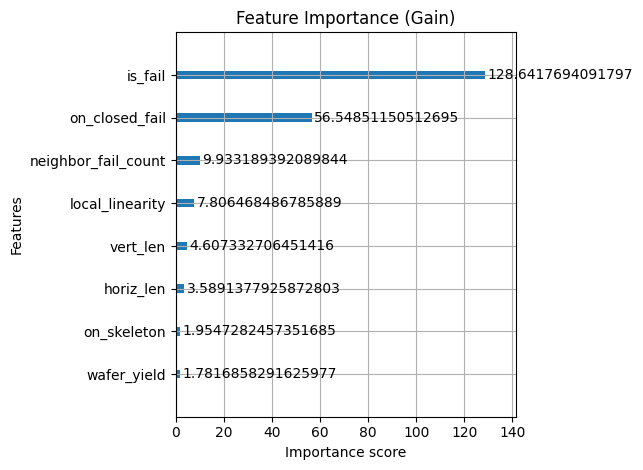

In [21]:
# Assign feature names so XGBoost can map f0→actual names
bst_full.feature_names = feature_cols

#Uses best_iteration if available to determine number of trees
if hasattr(bst_full, "best_iteration"):
    n_trees = bst_full.best_iteration + 1
else:
    n_trees = "Unknown"
print(f"Total number of trees: {n_trees}")

# Extract feature importances by three metrics
gain   = bst_full.get_score(importance_type="gain")
weight = bst_full.get_score(importance_type="weight")
cover  = bst_full.get_score(importance_type="cover")

# Build a DataFrame for easy viewing
imp_df = pd.DataFrame({
    "feature": feature_cols,
    "gain":    [gain.get(f, 0) for f in feature_cols],
    "weight":  [weight.get(f, 0) for f in feature_cols],
    "cover":   [cover.get(f, 0) for f in feature_cols],
})
imp_df = imp_df.sort_values("gain", ascending=False).reset_index(drop=True)


print("\nFeature importances (sorted by gain):")
print(imp_df.to_string(index=False))

# Plot gain-based importance
plt.figure(figsize=(8, 6))
xgb.plot_importance(
    bst_full,
    importance_type="gain",
    title="Feature Importance (Gain)"
)
plt.tight_layout()
plt.show()

### Save the model and its parameters for later inference



In [22]:
# Save the model
bst_full.save_model("xgb_scratch_detector_full.json")

# Save the best parameters to a JSON file with timestamp
now = datetime.now()
datetime_str = now.strftime("%Y-%m-%d_%H-%M-%S")
with open(f"xgb_scratch_params_{datetime_str}.json", "w") as f:
    json.dump(best_params, f, indent=2)

print("Model and parameters saved.")

Model and parameters saved.


### *7.* Prediction on Test Set

Apply the model to unseen wafers, filter them based on yield, and output the scratch predictions in CSV format.


In [23]:

# Load test data and featurize
zf = zipfile.ZipFile("./data.zip")
df_test = pd.read_csv(zf.open("wafers_test.csv"))

rows = []
for name, grp in df_test.groupby("WaferName"):
    feats = compute_wafer_features(grp)
    feats["WaferName"] = name
    rows.append(feats)
df_test_feats = pd.concat(rows, ignore_index=True)

# Filter out low-yield wafers, low‐yield wafers will not be predicted
df_test_feats = df_test_feats[df_test_feats["wafer_yield"] >= yield_threshold]

# # prepare DMatrix and predict
# X_test = df_test_feats[feature_cols].values
# dtest = xgb.DMatrix(X_test, feature_names=feature_cols)

# # Simply call predict()—the Booster only contains trees up to the early-stopped iteration
# probs = bst_full.predict(dtest)

# # Threshold & save
# threshold = best_thresh
# df_test_feats["PredictedScratch"] = (probs >= threshold).astype(int)
# df_test_feats.to_csv("scratch_predictions_test.csv", index=False)

# print(f"Predicted {df_test_feats.shape[0]} dies across {df_test_feats['WaferName'].nunique()} wafers.")  